# Imports

In [1]:
import pandas as pd
%load_ext autoreload
%autoreload 2

In [2]:
import pydotplus
from IPython.display import Image
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
#from keras.layers import InputLayer, Dense, Dropout, Softmax
from classification_utilities import *
from sklearn.preprocessing import MinMaxScaler

In [3]:
tr, ts, tr_target, ts_target = prepare_data(MinMaxScaler(),k=15)

Index(['statuses_count', 'user_subscription_in_secs', 'n_tweets',
       '2018_tweets', '2019_tweets', '2020_tweets',
       'publication_date_in_secs_std', 'retweet_count_entropy',
       'num_hashtags_mean', 'num_urls_mean', 'num_urls_std',
       'num_mentions_mean', 'num_mentions_std', 'tweeting_regularity',
       'max_daily_tweets'],
      dtype='object')


In [4]:
print(f'Number of samples in Training set:', len(tr))
print(f'Number of samples in Test set:', len(ts))
tr.shape

Number of samples in Training set: 9206
Number of samples in Test set: 2302


(9206, 15)

# Decision Tree

In [20]:
parameters = {
    'criterion': ['gini'], #,'entropy','log_loss'],
    'splitter': ['random','best'],
    'max_depth': [4,8,16,None],
    'min_samples_split': [2,4,8,16,32],
    'min_samples_leaf': [1,2,4,8],
    'max_features': ['sqrt', 'log2', None],
    'random_state': [42],
    'max_leaf_nodes': [None],
    'min_impurity_decrease': [0.0, 1e-2],
}

d_tree = DecisionTreeClassifier()

Fitting 5 folds for each of 960 candidates, totalling 4800 fits
Best combo:
	params: {'criterion': 'gini', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 8, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
	mean_train_accuracy: 0.8581088600789221
	mean_train_recall: 0.9913141090273576
	mean_train_precision: 0.7933186263994445
	mean_train_f1: 0.8813305782704024
	mean_val_accuracy: 0.8571586041434074
	mean_val_recall: 0.9905980602885546
	mean_val_precision: 0.7925578236340686
	mean_val_f1: 0.8805706970640654

Accuracy 0.8570807993049522
Precision test set  0.8810086126363458
Recall test set  0.8570807993049522
F1 score test set  0.8534137779701146
Support test set  (array([0.97953964, 0.79407895]), array([0.70991659, 0.98691742]), array([0.82321333, 0.88005833]), array([1079, 1223], dtype=int64))
              precision    recall  f1-score   support

genuine_user       0.98      0.71      0.82      1079
     

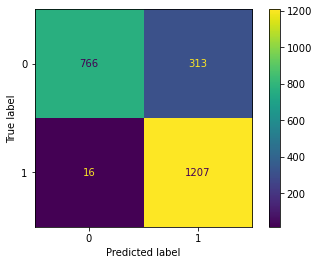

In [21]:
d_tree, results_df = grid_search(DecisionTreeClassifier, parameters, 'decision_tree', tr, ts, tr_target, ts_target)

In [26]:
dot_data = export_graphviz(d_tree, out_file=None, feature_names=list(ts.columns), filled=True, rounded=True,
                           class_names=['genuine user', 'bot'])
graph = pydotplus.graph_from_dot_data(dot_data)
with open('./classification/decision_tree/dtree_graph.png', 'wb') as png:
    png.write(Image(graph.create_png()).data)

# Naive Bayes

In [27]:
labels = ['genuine user','bot']
parameters = {
    'alpha':[0.25,0.5,0.75,1, 2],
    'fit_prior': [True, False]
}

In [28]:
best_nb, results_df = grid_search(MultinomialNB, parameters, 'mn_naive_bayes', tr, ts, tr_target, ts_target)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\al\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\al\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\al\anaconda3\lib\site-packages\sklearn\naive_bayes.py", line 690, in fit
    self._count(X, Y)
  File "C:\Users\al\anaconda3\lib\site-packages\sklearn\naive_bayes.py", line 863, in _count
    check_non_negative(X, "MultinomialNB (input X)")
  File "C:\Users\al\anaconda3\lib\site-packages\sklearn\ut

# Adaboost

In [19]:
# TODO add random state to make replicable grid?
parameters = {
    'base_estimator': [DecisionTreeClassifier(max_depth=4), DecisionTreeClassifier(max_depth=4, min_samples_split=2, criterion='gini', min_impurity_decrease=0.0, min_samples_leaf=8, splitter='best'), SVC(C=10000, gamma='auto', kernel='rbf', tol=0.1)],
    'n_estimators': [4,8,16,32,64,128,256],
    'learning_rate': [1e-3,1e-2, 1e-1, 1, 1e1, 1e2],
    'algorithm': ['SAMME']#,'SAMME.R'],
}

In [20]:
results_df = grid_search(AdaBoostClassifier, parameters, 'adaboost', tr, tr_target)

Fitting 4 folds for each of 126 candidates, totalling 504 fits


KeyboardInterrupt: 

# Random Forest

In [61]:
parameters = {
    "n_estimators": range(50,500,100),
    "criterion": ["gini","entropy","log_loss"],
    "max_depth": [None] + list(range(5,100,10)),
    "min_samples_split": [2,4,8,16,32,64],
    "min_samples_leaf": [2,4,8,16,32,64,128],
    "max_features":["auto","sqrt","log2",None],
    "max_leaf_nodes":[None] + list(range(1,10,2)),
    "min_impurity_decrease": 0.1 * np.array(range(1,5))
}

'  \n"max_depth": [None] + list(range(5,100,10)),\n    #"min_samples_split": [2,4,8,16,32,64],\n    "min_samples_split": [2,16,64],\n    #"min_samples_leaf": [2,4,8,16,32,64,128],\n    "min_samples_leaf": [2,16,64,128],\n    "max_features":["auto","sqrt","log2",None],\n    "max_leaf_nodes":[None] + list(range(1,10,2)),\n    "min_impurity_decrease": 0.1 * np.array(range(1,5))\n'

In [63]:
rf, results_df = grid_search(RandomForestClassifier, parameters, 'random_forest', tr, ts, tr_target, ts_target)

In [13]:
best_params = {'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'max_leaf_nodes': 9, 'min_impurity_decrease': 0.2, 'min_samples_leaf': 8, 'min_samples_split': 32, 'n_estimators': 50}

Accuracy 0.8266724587315378
Precision test set  0.8693097515589832
Recall test set  0.8266724587315378
F1 score test set  0.8191684696842777
Support test set  (array([1.       , 0.7540074]), array([0.63021316, 1.        ]), array([0.77316657, 0.85975395]), array([1079, 1223], dtype=int64))
              precision    recall  f1-score   support

genuine_user       1.00      0.63      0.77      1079
         bot       0.75      1.00      0.86      1223

    accuracy                           0.83      2302
   macro avg       0.88      0.82      0.82      2302
weighted avg       0.87      0.83      0.82      2302



RandomForestClassifier(max_depth=15, max_features='sqrt', max_leaf_nodes=9,
                       min_impurity_decrease=0.2, min_samples_leaf=8,
                       min_samples_split=32, n_estimators=50)

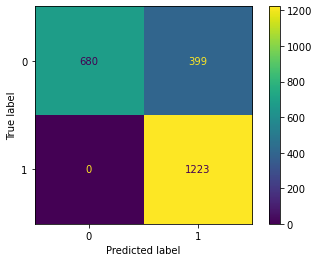

In [14]:
test_best(RandomForestClassifier, best_params, tr, ts, tr_target, ts_target, 'classification/random_forest/')

# SVM

In [4]:
parameters_linear = {
    'C': [10**(exp) for exp in [-2,-1,1,2,3,4]],
    'kernel': ['linear'],
    #'shrinking': [True, False],
    'tol': [1e-1],
    'random_state': [42]
}

gamma_range = ['scale','auto'] + [10**(exp) for exp in [-2,-1,0,1,2]]

parameters_poly = {
    **parameters_linear,
    'kernel': ['poly'],
    'degree': list(range(2,9)),
    'gamma': gamma_range,
}

parameters_rbf = {
    **parameters_linear,
    'kernel': ['rbf'],
    'gamma': gamma_range
}



Fitting 4 folds for each of 42 candidates, totalling 168 fits
Best combo:
	params: {'C': 10000, 'gamma': 'auto', 'kernel': 'rbf', 'random_state': 42, 'tol': 0.1}
	mean_train_accuracy: 0.8260192540210085
	mean_train_recall: 0.9994549851729231
	mean_train_precision: 0.753598732529071
	mean_train_f1: 0.8592860271372937
	mean_val_accuracy: 0.8239192456269722
	mean_val_recall: 0.997343268187624
	mean_val_precision: 0.7521824156683676
	mean_val_f1: 0.8575783538740558

Accuracy 0.8192875760208514
Precision test set  0.8640693108040707
Recall test set  0.8192875760208514
F1 score test set  0.8109918661456049
Support test set  (array([0.9970015 , 0.74678899]), array([0.6163114 , 0.99836468]), array([0.76174112, 0.85444367]), array([1079, 1223], dtype=int64))
              precision    recall  f1-score   support

genuine_user       1.00      0.62      0.76      1079
         bot       0.75      1.00      0.85      1223

    accuracy                           0.82      2302
   macro avg       0.8

(SVC(C=10000, gamma='auto', random_state=42, tol=0.1),
     mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
 0        3.797908      0.047242         2.326670        0.031133    0.01   
 1        5.281061      0.202921         3.248031        0.284869    0.01   
 2        5.477632      0.090869         3.022181        0.080973    0.01   
 3        4.846771      0.081484         3.414890        0.017962    0.01   
 4        4.483182      0.406781         2.279991        0.082845    0.01   
 5        4.121760      0.065707         2.287659        0.034237    0.01   
 6        5.337221      0.046832         2.844436        0.062553    0.01   
 7        3.337789      0.157328         1.508747        0.097473     0.1   
 8        3.943818      0.057689         2.112877        0.030150     0.1   
 9        5.038530      0.227978         2.813822        0.163688     0.1   
 10       3.821827      0.363598         2.044116        0.063475     0.1   
 11       3.166510   

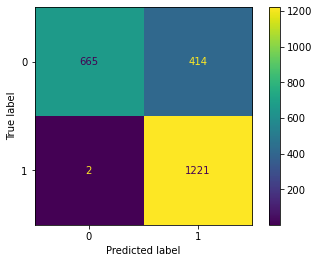

In [26]:
best_classifier, results_df = grid_search(SVC, parameters_rbf, 'svm',tr, ts, tr_target, ts_target, n_jobs=6)

In [27]:
results_df = pd.read_csv('classification/svm/gs_results.csv')

In [31]:
results_df.sort_values(by='mean_test_f1', ascending=False)[['params','mean_test_f1']]

,params,mean_test_f1
36,"{'C': 10000, 'gamma': 'auto', 'kernel': 'rbf',...",0.857578
38,"{'C': 10000, 'gamma': 0.1, 'kernel': 'rbf', 'r...",0.857453
31,"{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf', 'ra...",0.856775
29,"{'C': 1000, 'gamma': 'auto', 'kernel': 'rbf', ...",0.856246
37,"{'C': 10000, 'gamma': 0.01, 'kernel': 'rbf', '...",0.856201
25,"{'C': 100, 'gamma': 1, 'kernel': 'rbf', 'rando...",0.855638
21,"{'C': 100, 'gamma': 'scale', 'kernel': 'rbf', ...",0.855435
32,"{'C': 1000, 'gamma': 1, 'kernel': 'rbf', 'rand...",0.854879
28,"{'C': 1000, 'gamma': 'scale', 'kernel': 'rbf',...",0.854550
14,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf', '...",0.854206


In [ ]:
best_classifier, results_df = grid_search(SVC, parameters_poly, 'poly_svm', tr, ts, tr_target, ts_target, n_jobs=6)

Fitting 4 folds for each of 294 candidates, totalling 1176 fits


# NN

In [15]:
from keras.models import Model
input_layer = InputLayer(tr[0].shape, batch_size=64)
dense_layer = Dense(units=4, activation='sigmoid')(input_layer)
dense_layer = Dense(units=4, activation='sigmoid')(dense_layer)
out_layer = Softmax()(dense_layer)

model = Model(inputs=input_layer, outputs=out_layer)

model.compile(loss='binary_crossentropy', metrics=['precision','recall','accuracy','f1'])
model.fit(tr, tr_target, validation_split=0.2, epochs=3, workers=6)

ModuleNotFoundError: No module named 'tensorflow'

# Feature selection